In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)


In [4]:
# full_img_path = '/mnt/d/Datasets/CBIS_DDSM/full/'
roi_img_path = '/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
misclassified_store = '/mnt/c/Users/user/Desktop/CBIS_DDSM_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

Found 6672 files belonging to 2 classes.
Found 183 files belonging to 2 classes.


In [6]:
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
train_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
val_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
# test = test_ds.prefetch(AUTOTUNE)

Found 311 files belonging to 2 classes.
Found 6672 files belonging to 2 classes.
Found 183 files belonging to 2 classes.


In [7]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')
Model_Training = Model_Training()

# Inception V3

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

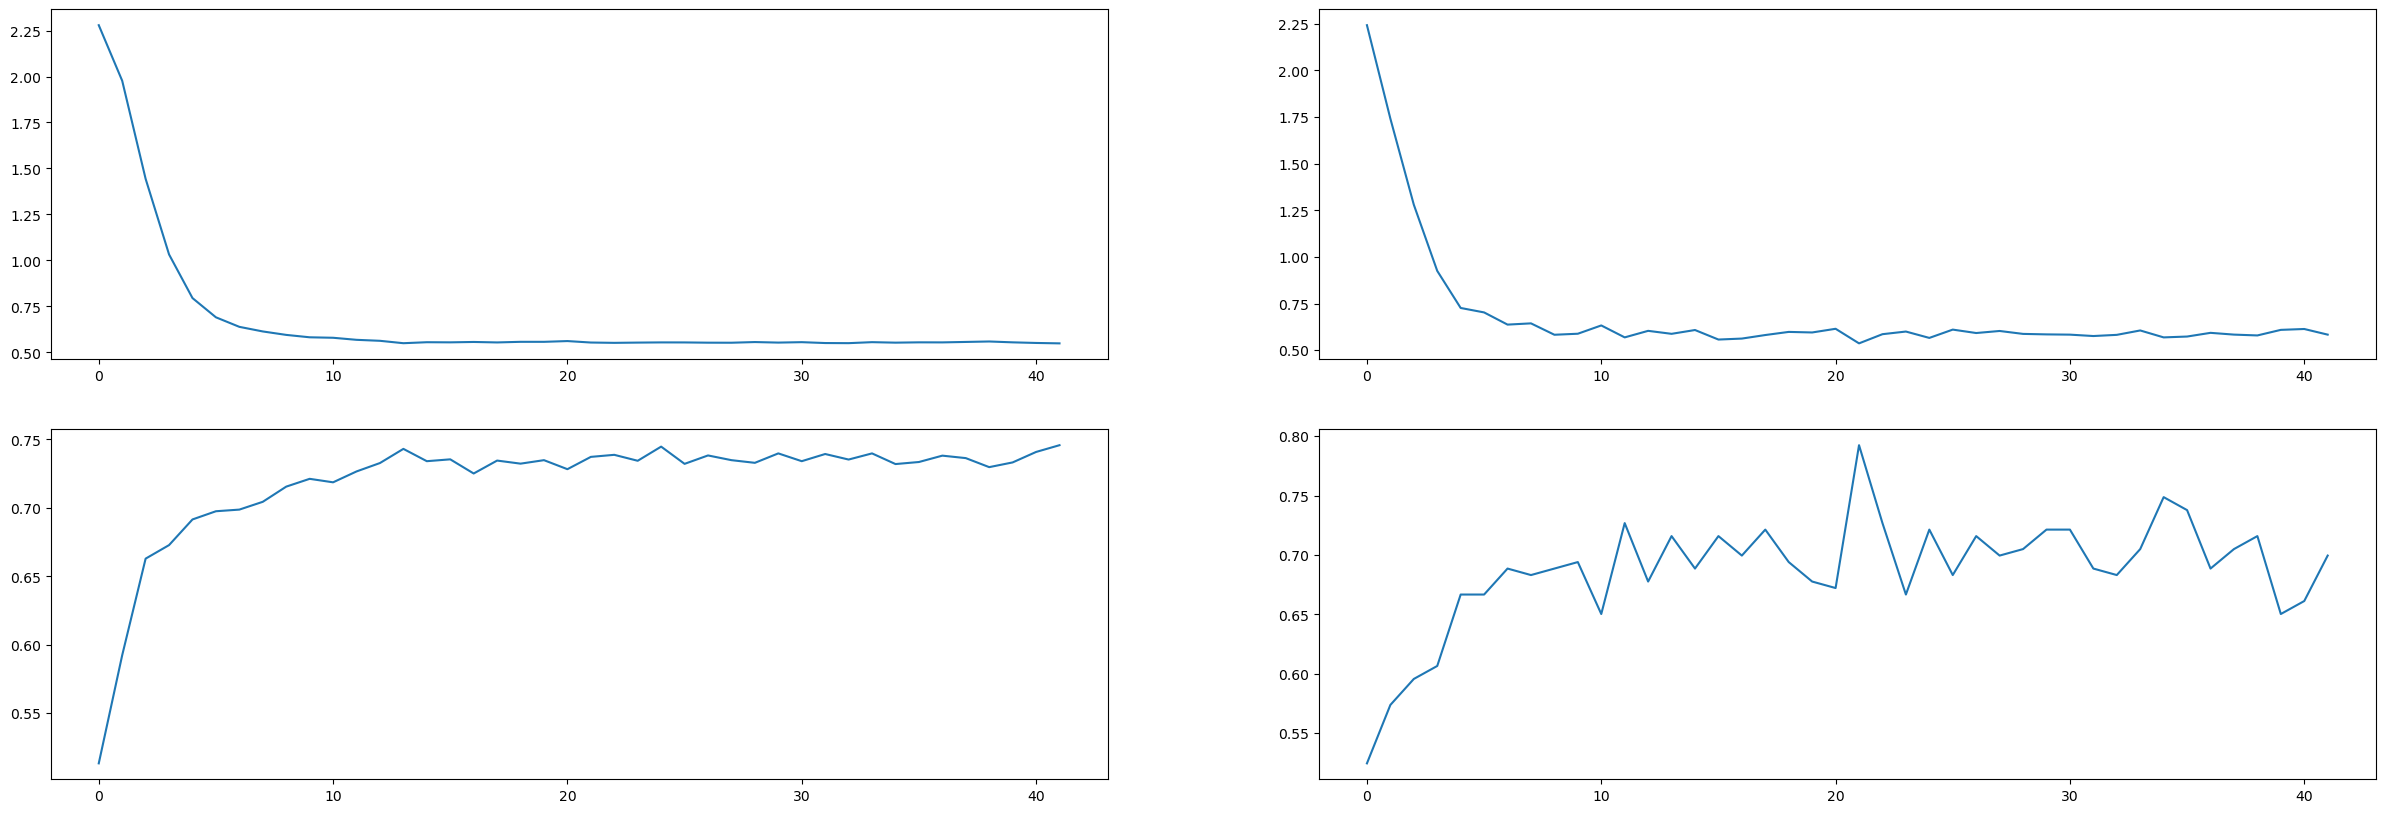

In [12]:
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log='/home/jj/FYP/log/InceptionV3_CBIS_DDSM/InceptionV3_CBIS_DDSM_dense.csv',
    load_weights = False,
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

2023-03-08 09:28:18.167242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-08 09:28:20.252439: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-03-08 09:28:20.931606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


417/417 [==============================] - 175s 389ms/step - loss: 0.5509 - categorical_accuracy: 0.7401 - precision: 0.7160 - precision_1: 0.7640 - val_loss: 0.5731 - val_categorical_accuracy: 0.7322 - val_precision: 0.6897 - val_precision_1: 0.7708
Epoch 2/2
417/417 [==============================] - 74s 177ms/step - loss: 0.5516 - categorical_accuracy: 0.7413 - precision: 0.7204 - precision_1: 0.7615 - val_loss: 0.6075 - val_categorical_accuracy: 0.7049 - val_precision: 0.6556 - val_precision_1: 0.7527
Epoch 3/3
417/417 [==============================] - 75s 178ms/step - loss: 0.5564 - categorical_accuracy: 0.7328 - precision: 0.7106 - precision_1: 0.7544 - val_loss: 0.5635 - val_categorical_accuracy: 0.7322 - val_precision: 0.6854 - val_precision_1: 0.7766
Epoch 4/4
417/417 [==============================] - 74s 178ms/step - loss: 0.5431 - categorical_accuracy: 0.7454 - precision: 0.7268 - precision_1: 0.7629 - val_loss: 0.5909 - val_categorical_accuracy: 0.7049 - val_precision: 0.

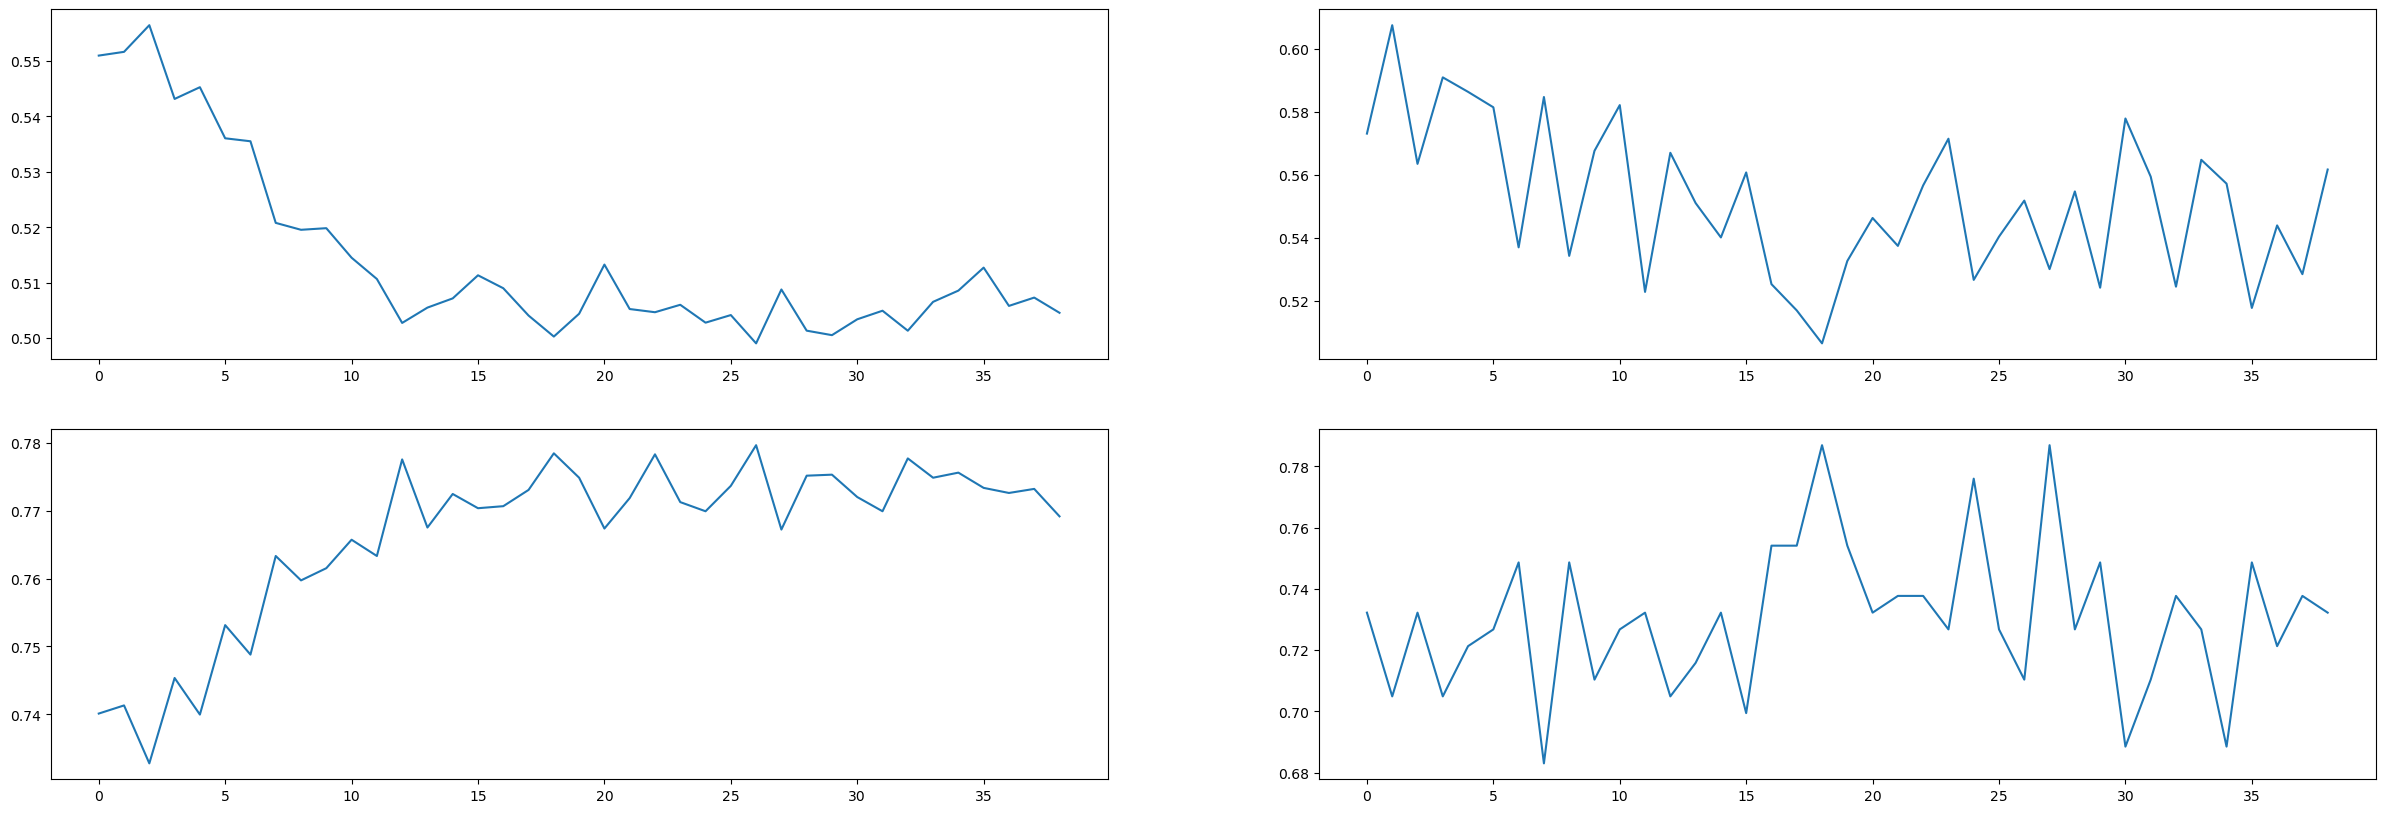

In [15]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log='/home/jj/FYP/log/InceptionV3_CBIS_DDSM/InceptionV3_CBIS_DDSM_Fine_Tune.csv',
    load_weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Dense/best_model',
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [16]:
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
tf.keras.backend.clear_session()
model = Model_Training.build_model('inceptionv3',augmentation=False,Flatten='global_average_pooling',load_weights='/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [17]:
store_misclassified = misclassified_store+'inceptionv3/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 60ms/step


20/20 [==============================] - 1s 33ms/step


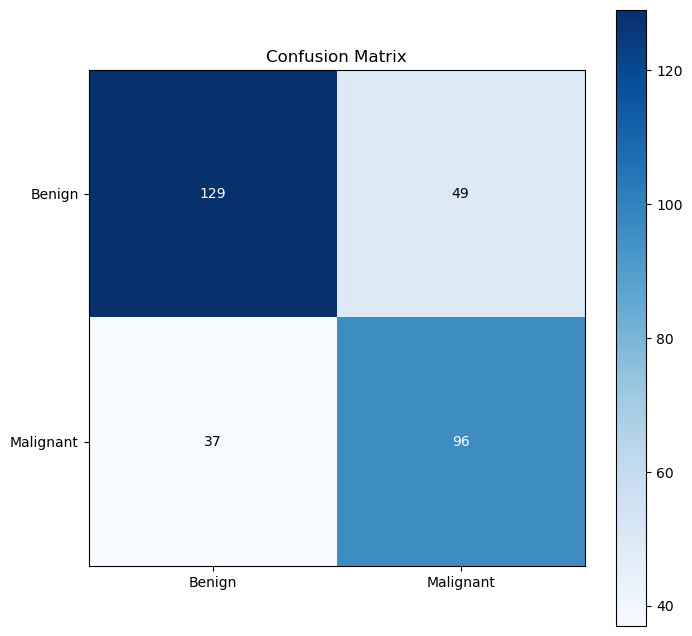

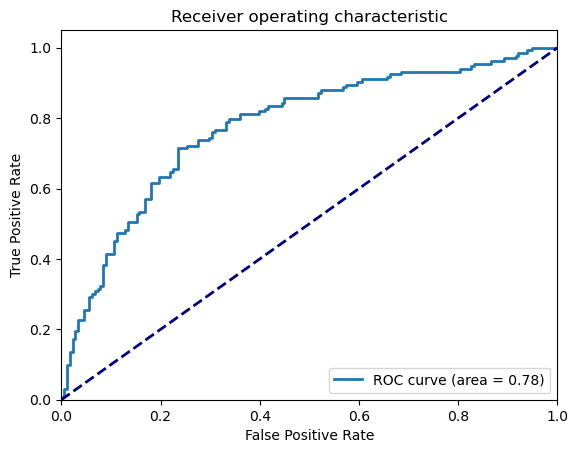

In [18]:
model.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

Image without padding, normalisation used

21/21 [==============================] - 2s 40ms/step - loss: 0.8528 - categorical_accuracy: 0.7019 - precision_2: 0.7778 - precision_3: 0.6331


# Resnet50

## Initialising

In [8]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Resnet50_CBIS_DDSM/'

In [9]:
tf.keras.backend.clear_session()
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

2023-03-08 11:16:36.312972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-08 11:16:38.927411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 11:16:38.938339: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd858038850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 11:16:38.938362: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-08 11:16:38.955692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 11:16:39.098859: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

417/417 [==============================] - 82s 178ms/step - loss: 2.3417 - categorical_accuracy: 0.5189 - precision: 0.4931 - precision_1: 0.5407 - val_loss: 2.2426 - val_categorical_accuracy: 0.5683 - val_precision: 0.5283 - val_precision_1: 0.5846
Epoch 2/2
417/417 [==============================] - 72s 173ms/step - loss: 2.0626 - categorical_accuracy: 0.5781 - precision: 0.5572 - precision_1: 0.5961 - val_loss: 1.8617 - val_categorical_accuracy: 0.6393 - val_precision: 0.5714 - val_precision_1: 0.7465
Epoch 3/3
417/417 [==============================] - 72s 172ms/step - loss: 1.5976 - categorical_accuracy: 0.6623 - precision: 0.6350 - precision_1: 0.6905 - val_loss: 1.3554 - val_categorical_accuracy: 0.7377 - val_precision: 0.6889 - val_precision_1: 0.7849
Epoch 4/4
417/417 [==============================] - 72s 172ms/step - loss: 1.1728 - categorical_accuracy: 0.6942 - precision: 0.6714 - precision_1: 0.7164 - val_loss: 1.0341 - val_categorical_accuracy: 0.6831 - val_precision: 0.7

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

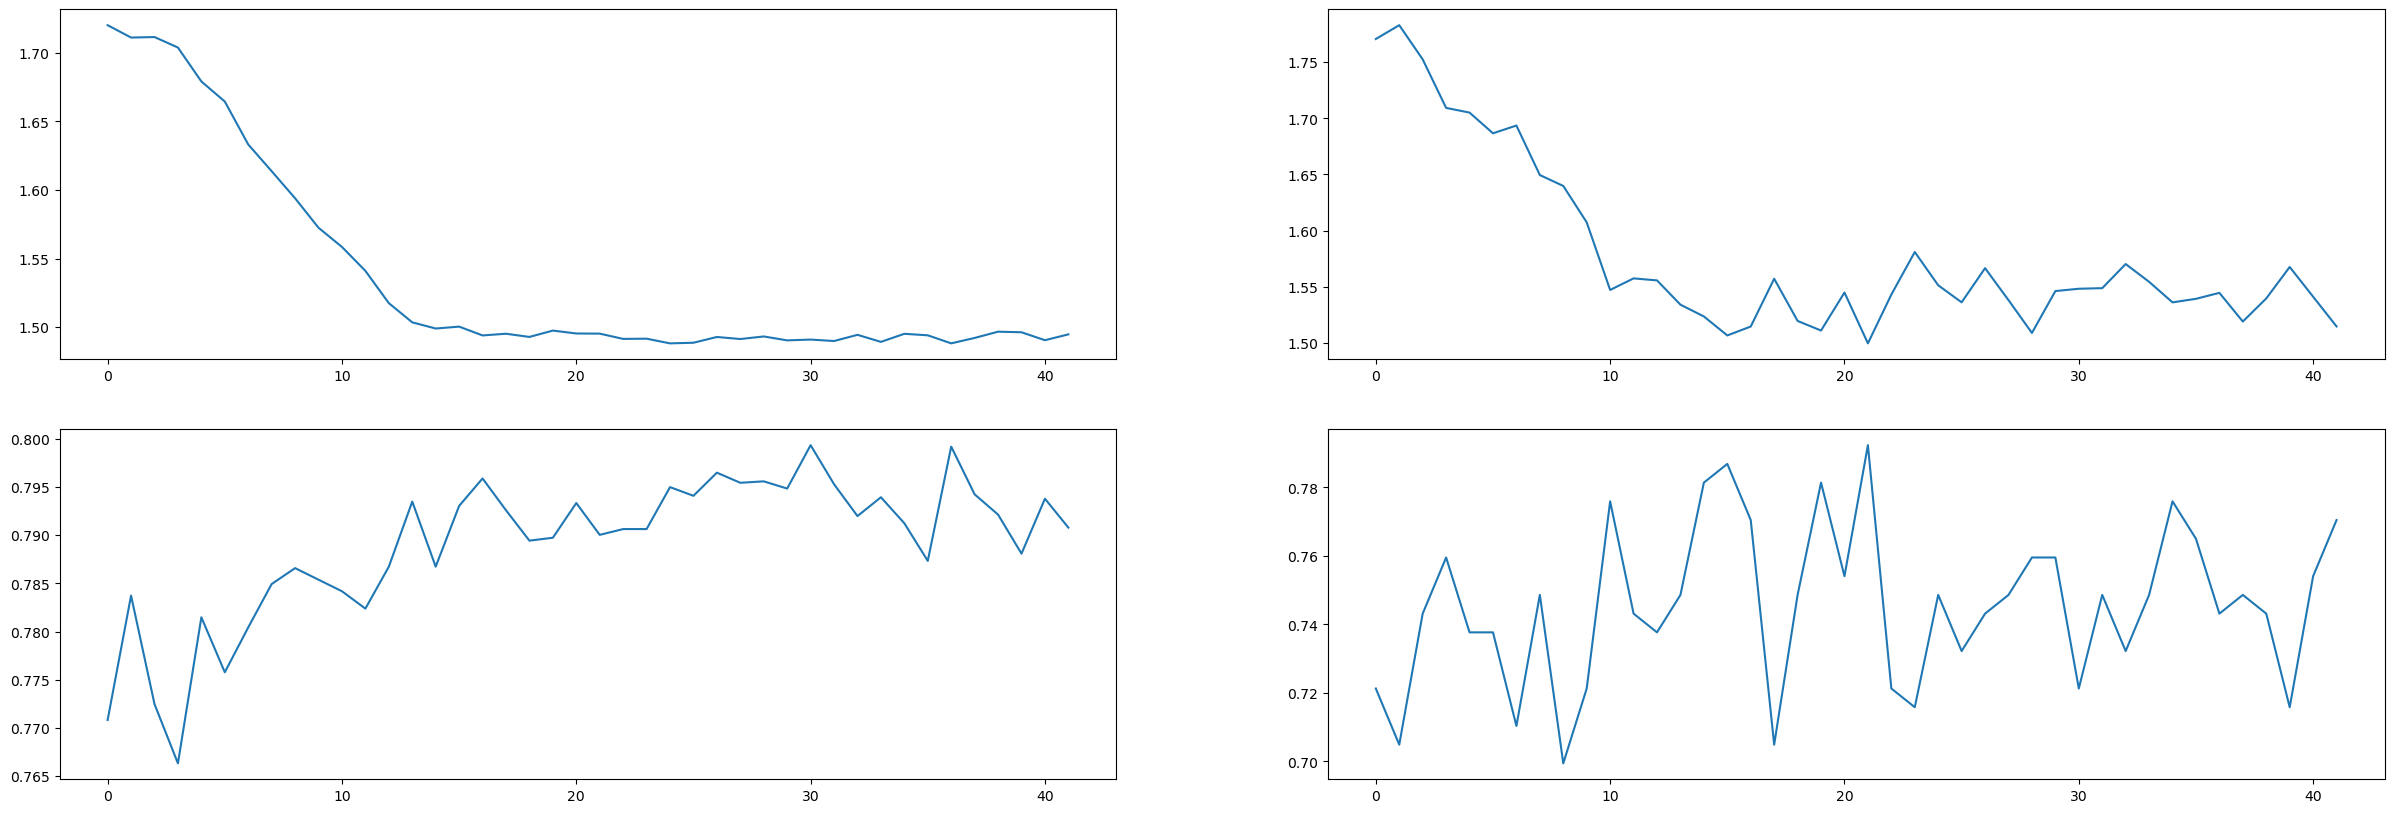

In [ ]:
tf.keras.backend.clear_session()
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 22,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              419635

In [ ]:
store_misclassified = misclassified_store+'resnet50/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 65ms/step


20/20 [==============================] - 1s 40ms/step


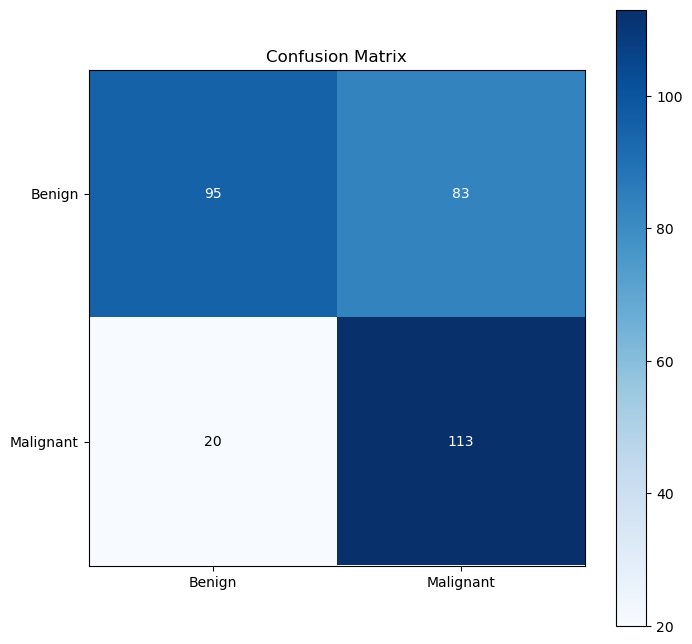

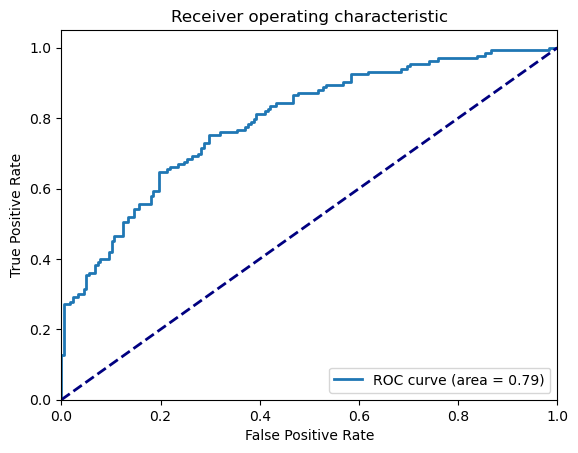

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# VGG16

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2023-03-05 02:04:34.121681: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 02:04:34.126280: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


56/56 [==============================] - 22s 292ms/step - loss: 2.2423 - categorical_accuracy: 0.5553 - precision: 0.5109 - precision_1: 0.5749 - val_loss: 2.0714 - val_categorical_accuracy: 0.6009 - val_precision: 0.5783 - val_precision_1: 0.6138
Epoch 2/2
56/56 [==============================] - 12s 213ms/step - loss: 1.9927 - categorical_accuracy: 0.5318 - precision: 0.4701 - precision_1: 0.5559 - val_loss: 1.8806 - val_categorical_accuracy: 0.5702 - val_precision: 0.7143 - val_precision_1: 0.5607
Epoch 3/3
56/56 [==============================] - 12s 219ms/step - loss: 1.7942 - categorical_accuracy: 0.5754 - precision: 0.5789 - precision_1: 0.5747 - val_loss: 1.7073 - val_categorical_accuracy: 0.5351 - val_precision: 0.4167 - val_precision_1: 0.5417
Epoch 4/4
56/56 [==============================] - 12s 214ms/step - loss: 1.6366 - categorical_accuracy: 0.5799 - precision: 0.5933 - precision_1: 0.5772 - val_loss: 1.5603 - val_categorical_accuracy: 0.5746 - val_precision: 0.5946 - va

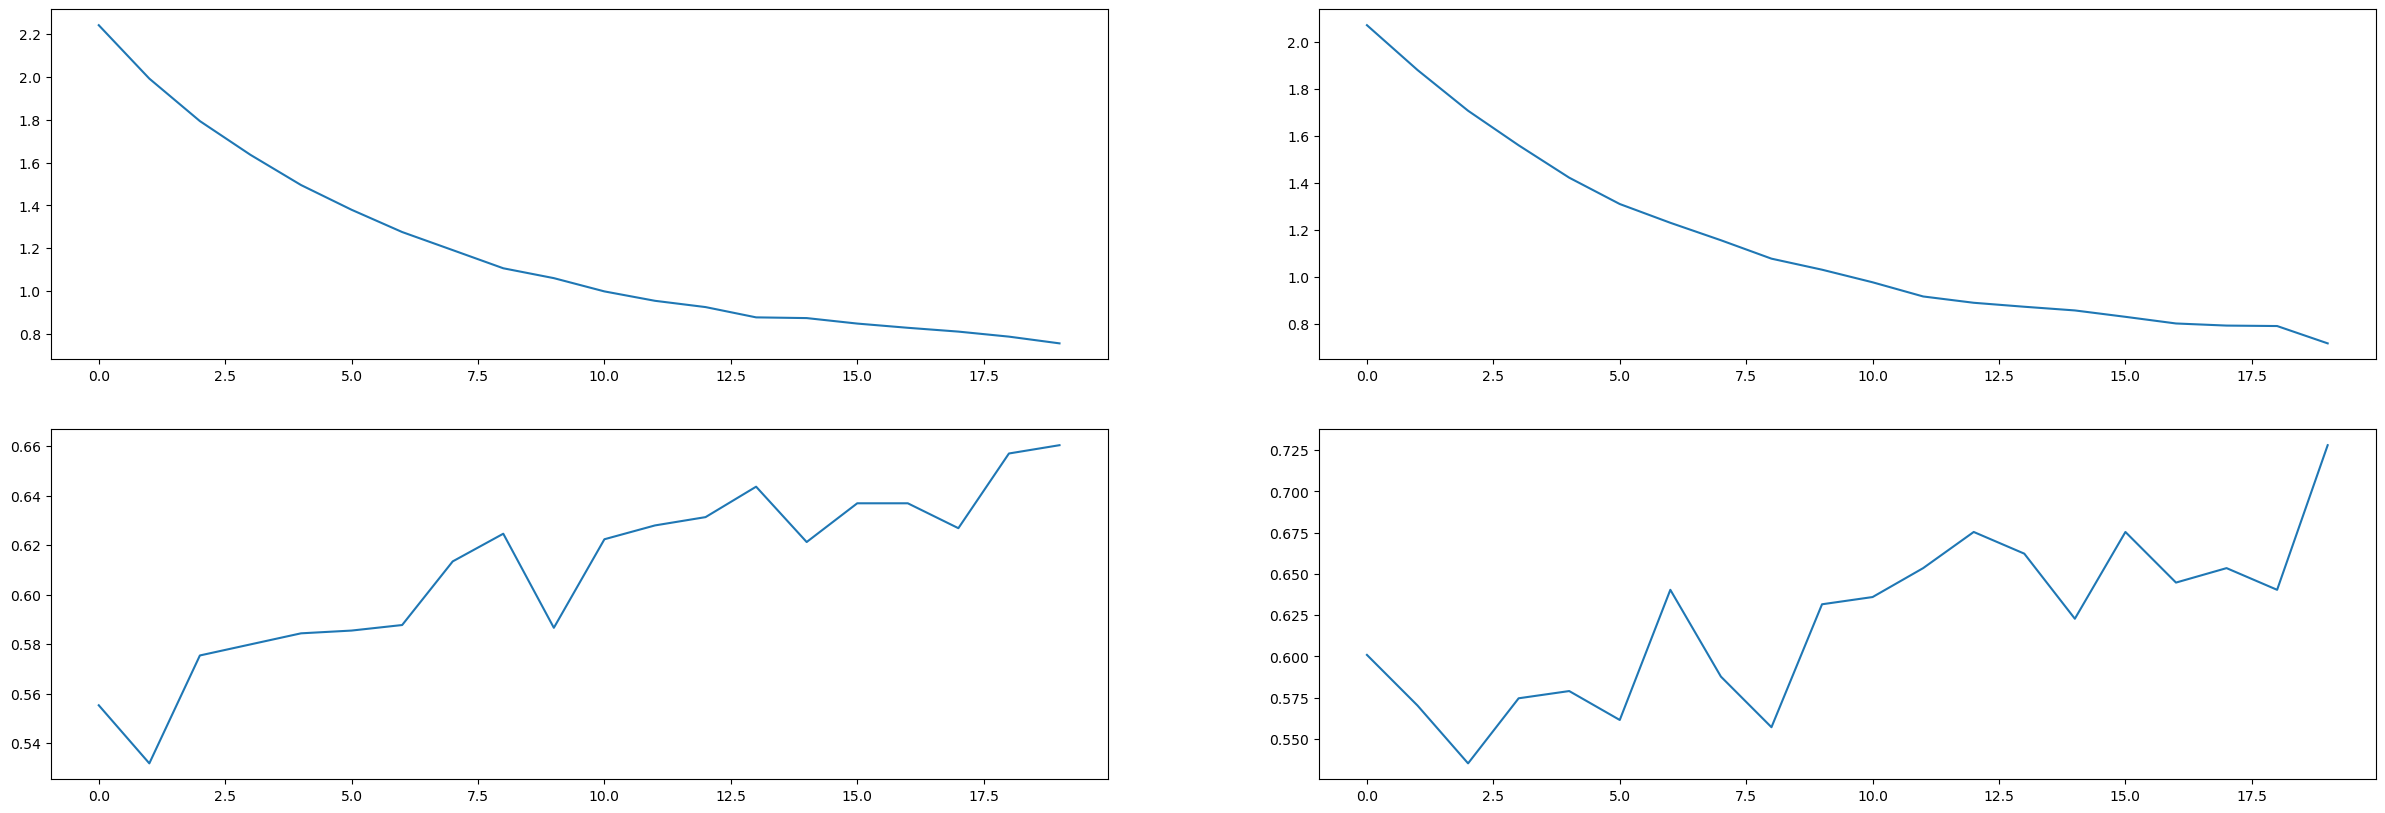

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

2023-03-05 02:08:55.636962: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 02:08:55.637020: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 02:08:55.673512: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 02:08:55.673556: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

56/56 [==============================] - 21s 309ms/step - loss: 0.7663 - categorical_accuracy: 0.6525 - precision_2: 0.6054 - precision_3: 0.6982 - val_loss: 0.7685 - val_categorical_accuracy: 0.6360 - val_precision_2: 0.6082 - val_precision_3: 0.6565
Epoch 2/2
56/56 [==============================] - 15s 273ms/step - loss: 0.7508 - categorical_accuracy: 0.6749 - precision_2: 0.6423 - precision_3: 0.7008 - val_loss: 0.7469 - val_categorical_accuracy: 0.6667 - val_precision_2: 0.6489 - val_precision_3: 0.6791
Epoch 3/3
56/56 [==============================] - 15s 272ms/step - loss: 0.7425 - categorical_accuracy: 0.6682 - precision_2: 0.6412 - precision_3: 0.6880 - val_loss: 0.7489 - val_categorical_accuracy: 0.6754 - val_precision_2: 0.6786 - val_precision_3: 0.6736
Epoch 4/4
56/56 [==============================] - 15s 273ms/step - loss: 0.7455 - categorical_accuracy: 0.6816 - precision_2: 0.6676 - precision_3: 0.6907 - val_loss: 0.7428 - val_categorical_accuracy: 0.6579 - val_precisio

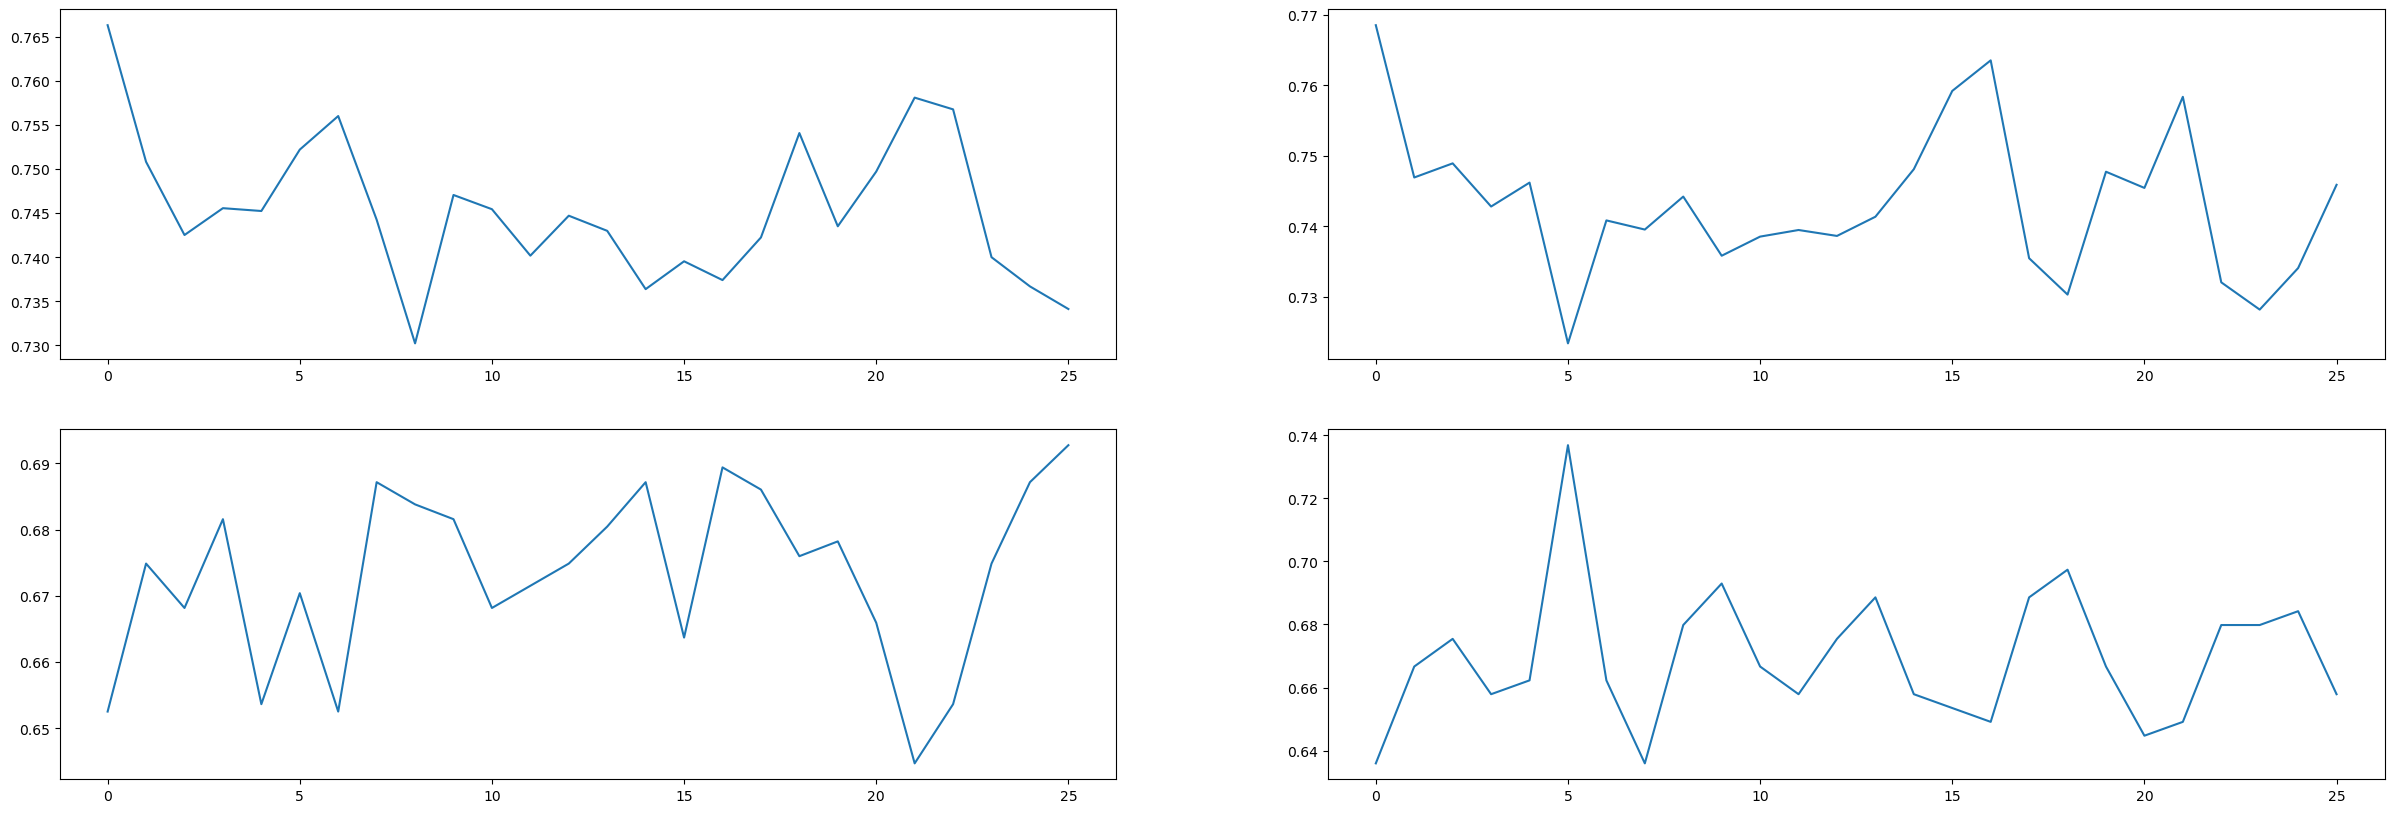

In [ ]:
tf.keras.backend.clear_session()
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 16,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-5,init_lr=1e-7,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('vgg16',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
store_misclassified = misclassified_store+'vgg16/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

2023-03-05 17:47:57.442456: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-05 17:47:57.442526: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


15/15 [==============================] - 2s 124ms/step


21/21 [==============================] - 5s 162ms/step


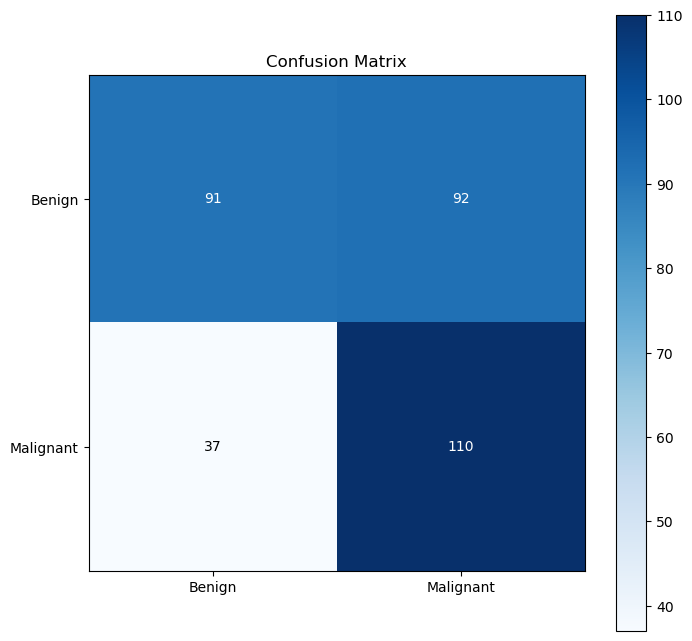

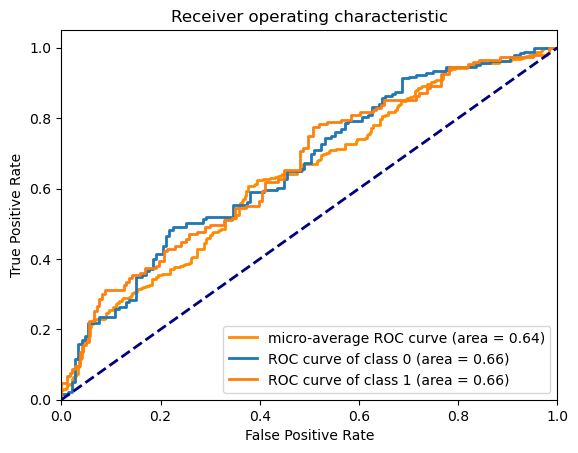

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet

In [ ]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              3147776   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

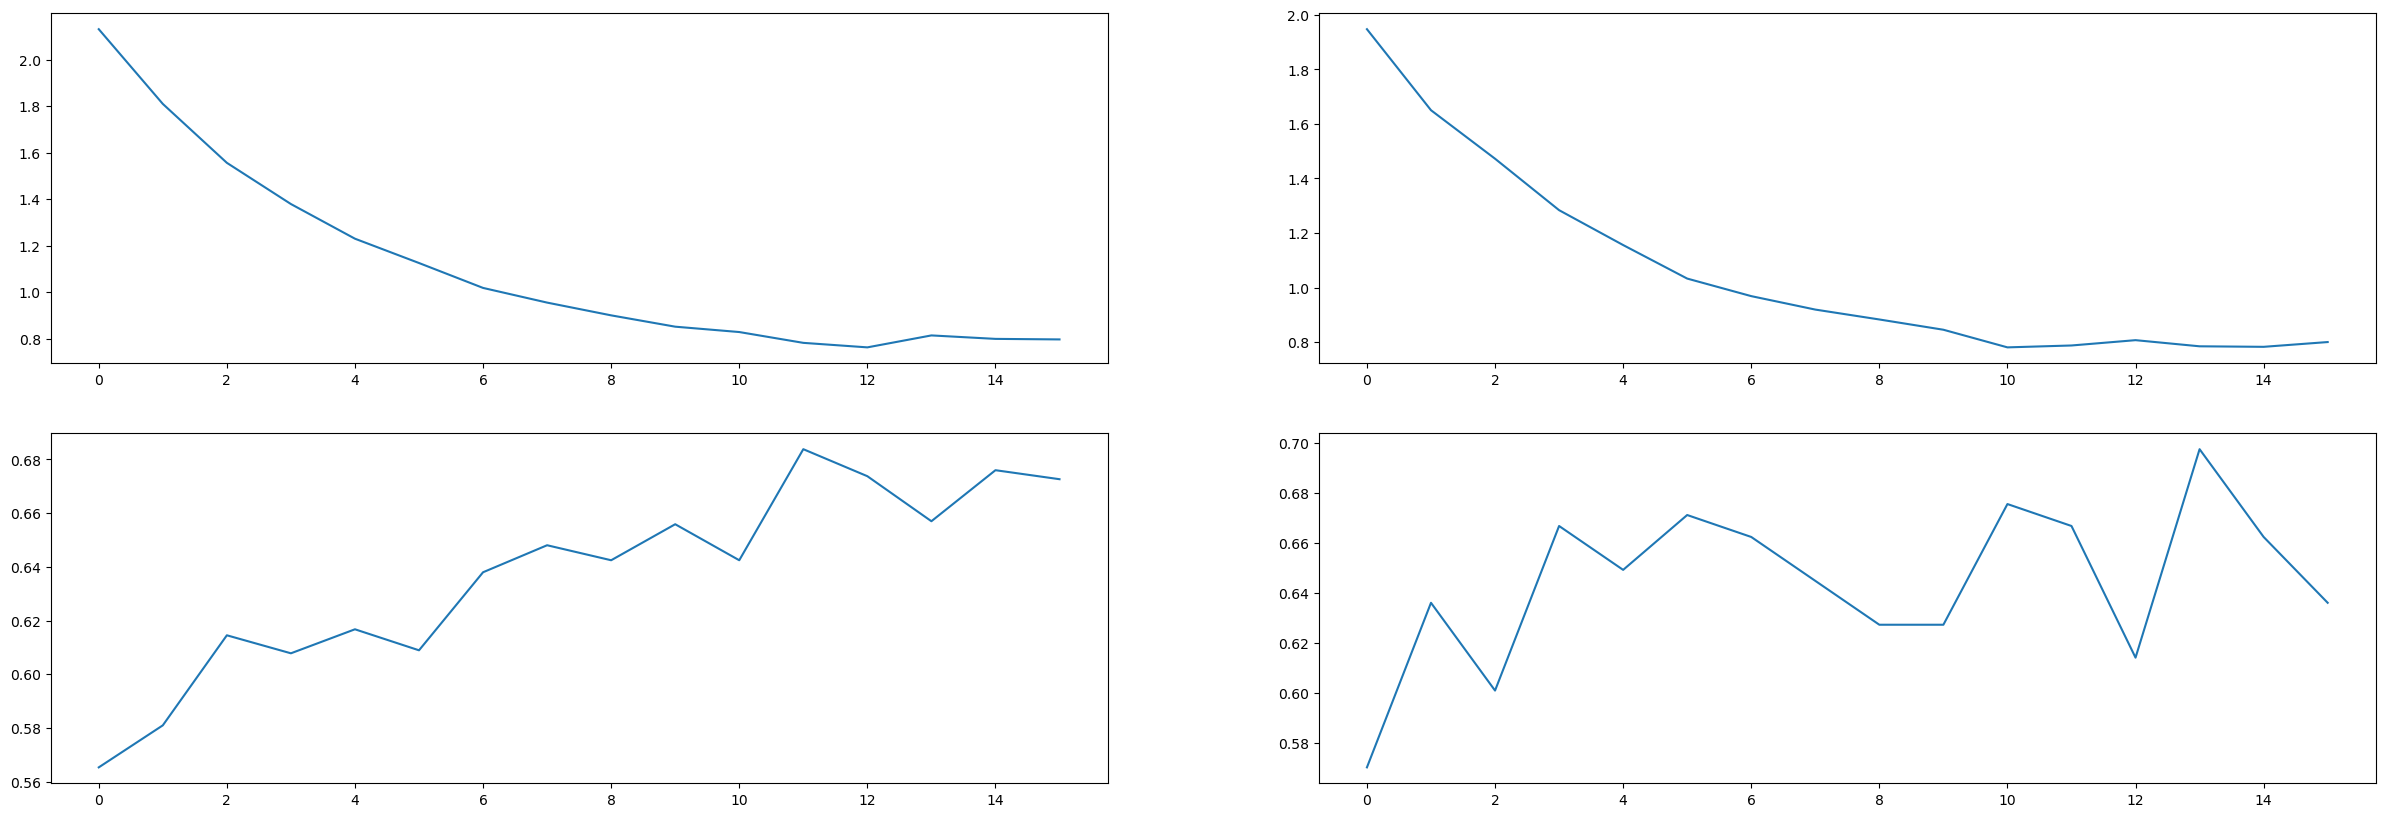

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=20,
    patience=2,
    Earlystop=5,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=1e-4),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
tf.keras.backend.clear_session()

## Fine Tune

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2048)              3147776   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

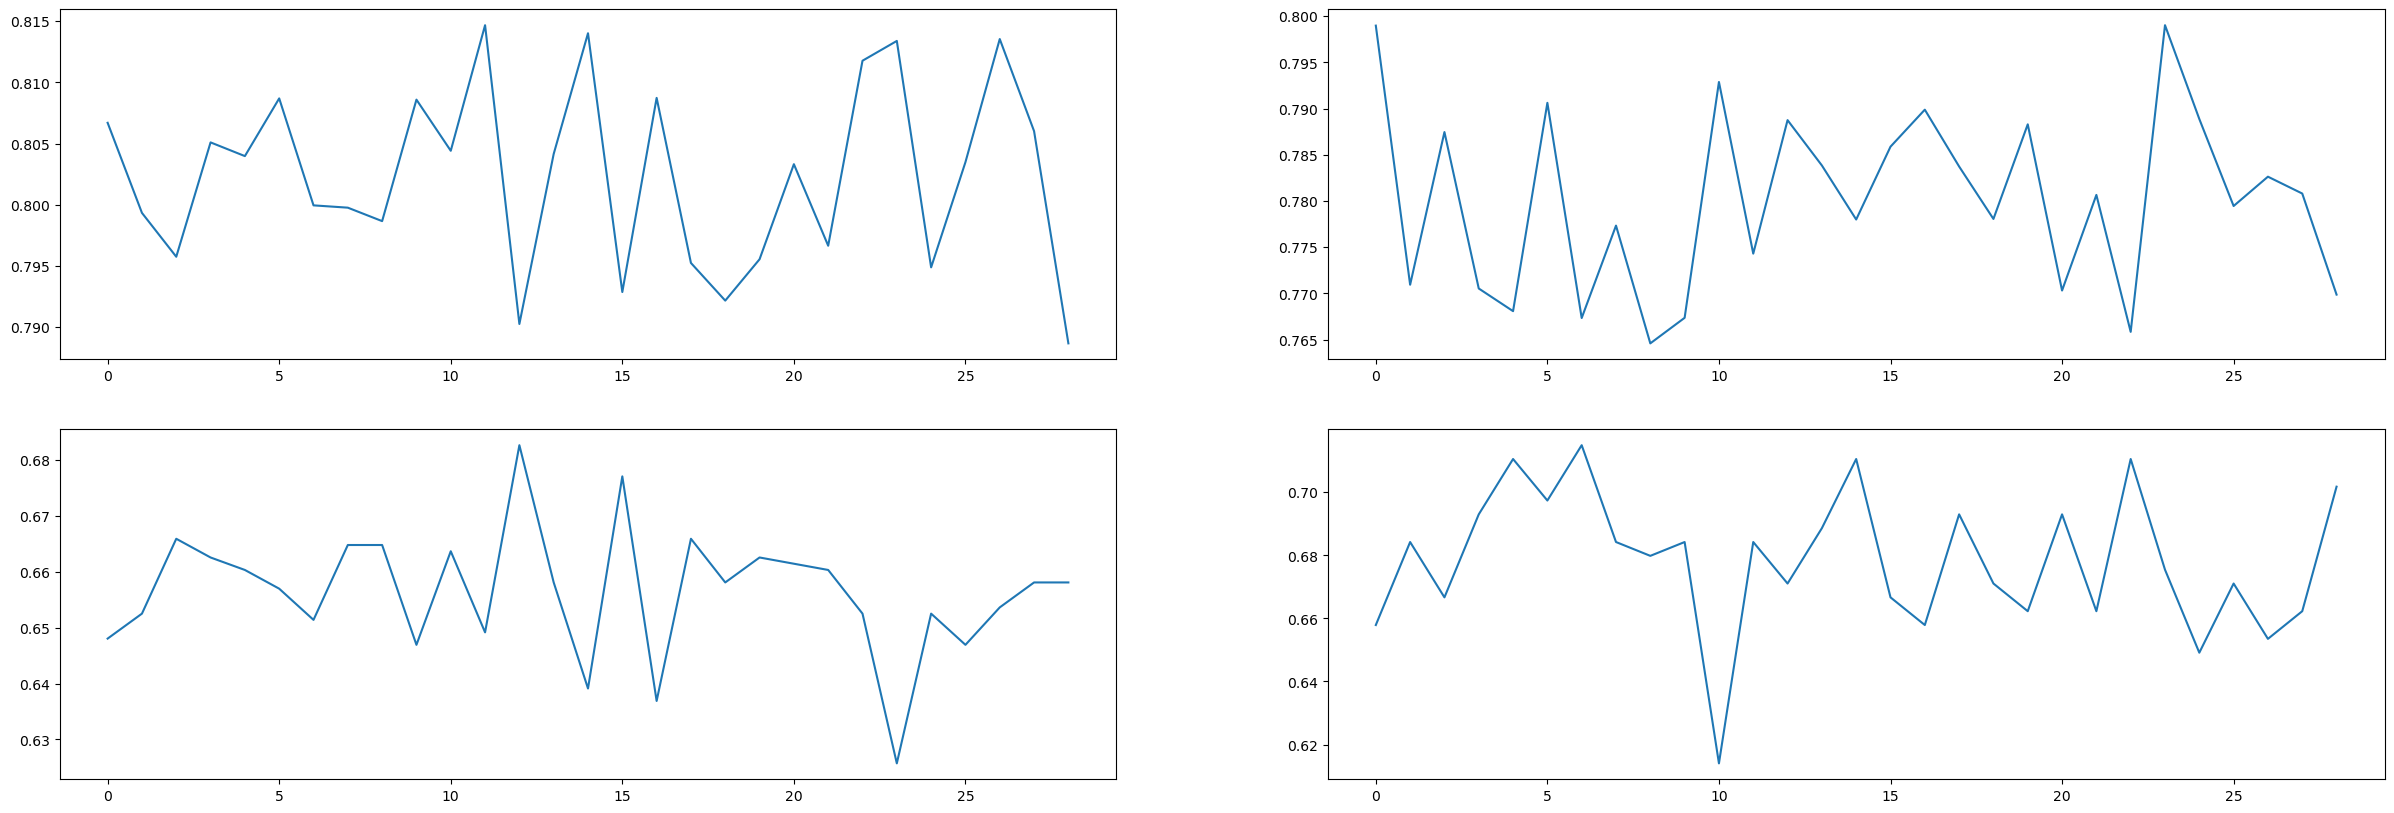

In [ ]:
tf.keras.backend.clear_session()
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=1e-4),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-5,init_lr=1e-7,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 2048)              3147776   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 8)                 16392     
                                                           

In [ ]:
store_misclassified = misclassified_store+'efficientnetb3/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

15/15 [==============================] - 2s 111ms/step


21/21 [==============================] - 6s 183ms/step


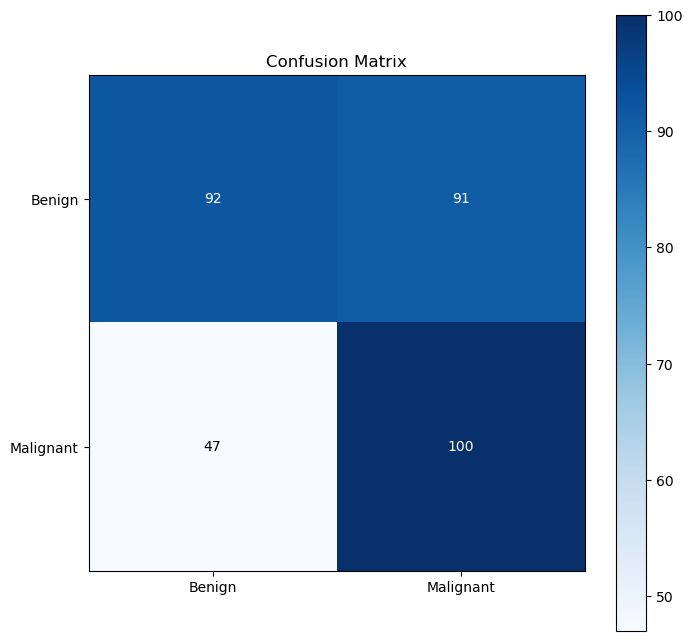

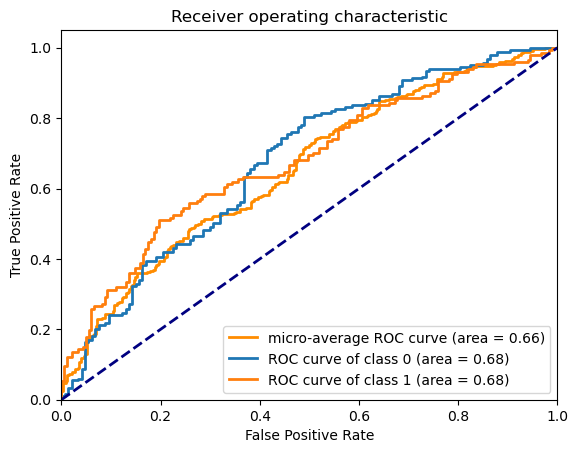

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# ConvNext

In [ ]:
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

2023-03-07 16:11:22.401470: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa0d8003bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-07 16:11:22.403138: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-07 16:11:23.247165: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-07 16:11:25.191277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


417/417 [==============================] - 172s 379ms/step - loss: 0.7210 - categorical_accuracy: 0.5006 - precision: 0.4808 - precision_1: 0.5359 - val_loss: 0.6948 - val_categorical_accuracy: 0.5082 - val_precision: 0.4535 - val_precision_1: 0.5567
Epoch 2/2
417/417 [==============================] - 150s 359ms/step - loss: 0.6484 - categorical_accuracy: 0.6069 - precision: 0.5988 - precision_1: 0.6125 - val_loss: 0.5853 - val_categorical_accuracy: 0.6940 - val_precision: 0.6354 - val_precision_1: 0.7586
Epoch 3/3
417/417 [==============================] - 150s 359ms/step - loss: 0.5763 - categorical_accuracy: 0.7011 - precision: 0.6826 - precision_1: 0.7183 - val_loss: 0.5576 - val_categorical_accuracy: 0.6995 - val_precision: 0.6588 - val_precision_1: 0.7347
Epoch 4/4
417/417 [==============================] - 150s 359ms/step - loss: 0.5515 - categorical_accuracy: 0.7196 - precision: 0.6985 - precision_1: 0.7398 - val_loss: 0.5496 - val_categorical_accuracy: 0.7268 - val_precision:

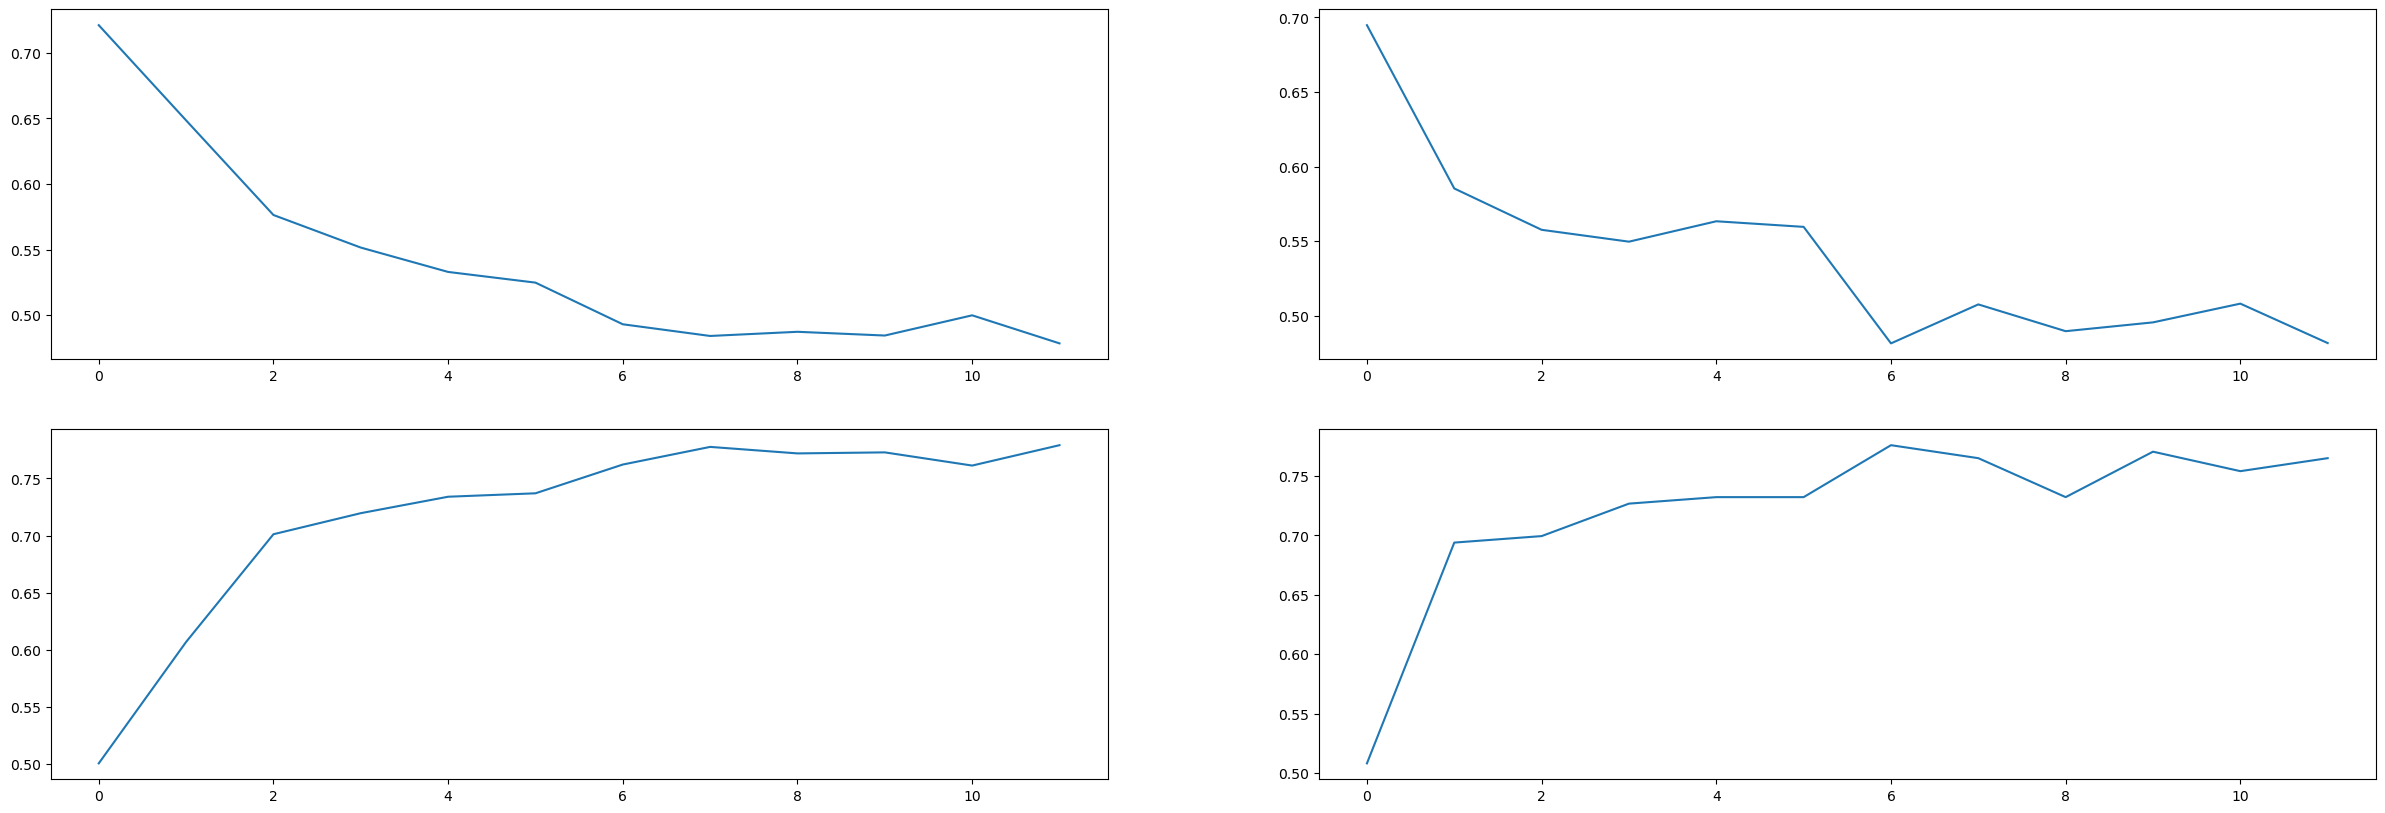

In [ ]:
tf.keras.backend.clear_session()
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=20,
    patience=1,
    Earlystop=5,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=1e-4),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=300,
    patience=1,
    Earlystop=20,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

: 

: 

## Test

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 16392     
                                                           

In [ ]:
store_misclassified = misclassified_store+'convnext/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

2023-03-05 17:50:13.474968: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f84e002d0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 17:50:13.475009: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-05 17:50:14.077172: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 5s 343ms/step


21/21 [==============================] - 5s 224ms/step


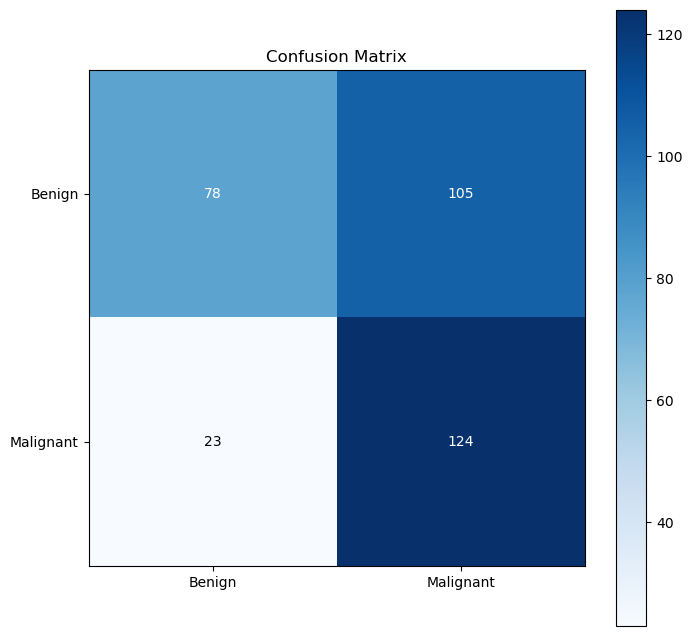

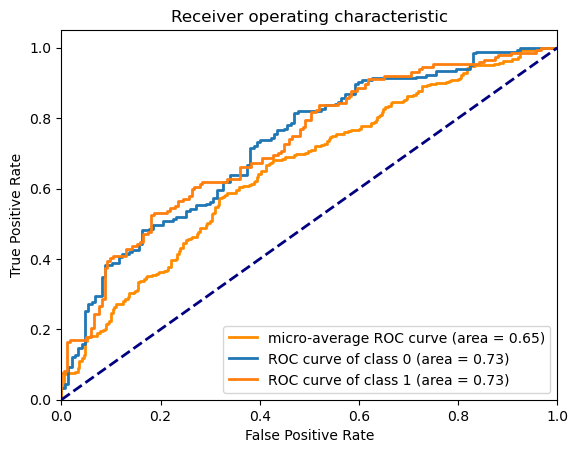

: 

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet V2M

## Initialising

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_CBIS_DDSM/'
model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=20,
    patience=2,
    Earlystop=5,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=1e-4),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

## Fine Tuning

In [ ]:
tf.keras.backend.clear_session()
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=1e-4),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-5,init_lr=1e-7,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1024008   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                           

2023-02-22 02:34:36.165409: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.166066: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.178397: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.178425: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

102/102 [==============================] - ETA: 0s - loss: 1.4916 - categorical_accuracy: 0.5724 - precision_2: 0.5415 - precision_3: 0.6320

2023-02-22 02:35:01.563317: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:35:01.563354: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 Epoch 0: accuracy=0.5724, loss=1.4916, val_accuracy=0.6412, val_loss=1.4200,  - lr=0.0010000
102/102 [==============================] - 41s 301ms/step - loss: 1.4916 - categorical_accuracy: 0.5724 - precision_2: 0.5415 - precision_3: 0.6320 - val_loss: 1.4200 - val_categorical_accuracy: 0.6412 - val_precision_2: 0.6344 - val_precision_3: 0.6463
Epoch 2/2
102/102 [==============================] - 29s 279ms/step - loss: 1.4567 - categorical_accuracy: 0.5362 - precision_2: 0.5128 - precision_3: 0.5965 - val_loss: 1.3928 - val_categorical_accuracy: 0.6481 - val_precision_2: 0.6210 - val_precision_3: 0.6761
Epoch 3/3
102/102 [==============================] - 29s 278ms/step - loss: 1.4083 - categorical_accuracy: 0.5755 - precision_2: 0.5427 - precision_3: 0.6434 - val_loss: 1.3608 - val_categorical_accuracy: 0.6435 - val_precision_2: 0.6491 - val_precision_3: 0.6398
Epoch 4/4
102/102 [==============================] - 29s 278ms/step - loss: 1.3811 - categorical_accuracy: 0.5583 - precisio

## Test

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

21/21 [==============================] - 3s 133ms/step - loss: 0.6264 - categorical_accuracy: 0.6759 - precision_2: 0.7619 - precision_3: 0.6045
